In [6]:
%reload_ext autoreload
%autoreload 2

import datasets
import torch.nn as nn
import data_process as dp
import torchtext
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.utils
import random
import numpy as np
from models import SentimentAnalysisLSTM
from training import *
from testing import *

In [7]:
#reproducibility
# torch.manual_seed(0)
# random.seed(0)
# np.random.seed(0)

## Load data

In [8]:
important_columns = ["position", "move", "comment", "sentiment"]
moves_df = datasets.load_sql_to_df("SELECT * FROM english_annotated_moves", "../../chess.db")[important_columns]
moves_df

,position,move,comment,sentiment
0,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,e2e4,This is my first gameknot game against someone...,2
1,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,b1c3,"I've been playing the Vienna Gambit as white, ...",-1
2,rnbqkbnr/pppp1ppp/8/4p3/4P3/2N5/PPPP1PPP/R1BQK...,f8c5,Minor disappointment.,-1
3,r1bqk2r/pppp1ppp/2n2n2/2b1p3/2B1P3/2NP4/PPP2PP...,f2f4,"My idea here is to expand on the kingside, dri...",-1
4,r1bqk2r/ppp2ppp/3p1n2/n1b1pP2/2B1P3/2NP4/PPP3P...,d1f3,"Maybe this isn't the greatest plan, since with...",0
...,...,...,...,...
326634,rnb5/p2p1P1N/7p/1pR5/6P1/4k3/2P1B3/3Q1RK1 b - ...,b5b4,Pawn,-1
326635,rnb5/p2p1P1N/7p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 w -...,f7f8q,Check mate in two moves,-1
326636,rnb2Q2/p2p3N/7p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 b -...,d7d6,Pawn,-1
326637,rnb2Q2/p6N/3p3p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 w -...,f8e8,Check,-1


## Preprocessing

In [9]:
glove_embbedings = torchtext.vocab.GloVe(name="6B", dim=200, cache="../../.vector_cache/")
datasets.add_padding_vector_to_embeddings(glove_embbedings)

In [10]:
comments_df = dp.prepare_data_for_sentiment_analysis_training(moves_df, glove_embbedings.stoi)
comments_df

,comment,sentiment
18080,"[mistake, .]",0
9826,"[?, ?]",0
11757,"[why, not]",0
13968,"[white, blunder]",0
547,"[!, win]",1
...,...,...
18753,"[calculate, only, two, variation, since, ken, ...",0
3470,"[lose, right, away, with, option, option, opti...",1
1826,"[?, white, have, great, choice, here, direct, ...",0
13404,"[lose, right, away, with, option, option, opti...",1


In [11]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [15]:
train_df, test_df = dp.df_train_test_split(comments_df, comment_col='comment', test_size=0.1)
display(train_df)
display(test_df)

,comment,sentiment
15697,"[attack, and]",1
3389,"[?, ?]",0
16965,"[allow, ...]",0
6236,"[?, need]",0
19247,"[correct, be]",0
...,...,...
8940,"[?, ?, do, not, know, if, really, be, a, two, ...",0
14708,"[do, not, know, why, make, this, move, but, th...",0
520,"[?, ?, completely, block, off, the, queenside,...",0
8234,"[?, know, that, be, still, a, pawn, up, once, ...",0


,comment,sentiment
16115,"[be, require]",0
11136,"[shut, down]",1
14075,"[lose, queen]",0
10948,"[direct, .]",1
11978,"[well, be]",0
...,...,...
18874,"[do, not, know, if, really, be, a, two, move, ...",0
15526,"[have, briefly, consider, my, response, if, wh...",0
19215,"[similar, to, much, early, in, the, game, when...",0
13404,"[lose, right, away, with, option, option, opti...",1


In [16]:
train_dataset = datasets.PretrainedEmbeddingsIndicesDataset(train_df, glove_embbedings)
test_dataset = datasets.PretrainedEmbeddingsIndicesDataset(test_df, glove_embbedings)

## Comments' length

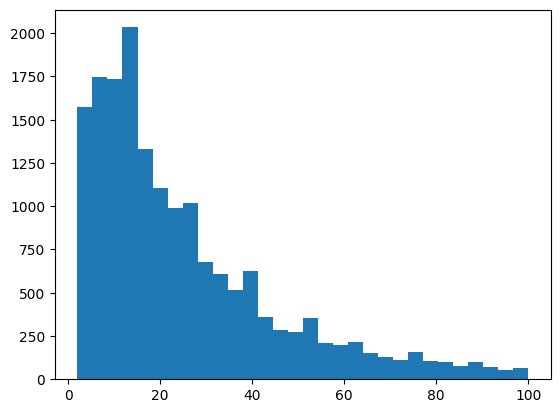

In [17]:
lengths = [len(x) for x,_ in train_dataset]
plt.hist(lengths, bins=30)
plt.show()

## Training

In [19]:
train_loader = datasets.DataLoaderPadding(dataset=train_dataset, batch_size=64)
test_loader = datasets.DataLoaderPadding(dataset=test_dataset, batch_size=64)

In [23]:
model = SentimentAnalysisLSTM(embeddings=glove_embbedings, hidden_dim=256, num_layers=3, dropout=0.2)
model.to(device)
# criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch 1/60  loss: 0.386596, err_rate: 19.54%
epoch 2/60  loss: 0.308098, err_rate: 14.92%
epoch 3/60  loss: 0.277269, err_rate: 13.53%
epoch 4/60  loss: 0.255975, err_rate: 11.86%
epoch 5/60  loss: 0.249575, err_rate: 11.65%
epoch 6/60  loss: 0.227733, err_rate: 10.30%
epoch 7/60  loss: 0.209886, err_rate: 9.34%
epoch 8/60  loss: 0.195038, err_rate: 8.59%
epoch 9/60  loss: 0.182374, err_rate: 7.60%
epoch 10/60  loss: 0.171417, err_rate: 7.24%
epoch 11/60  loss: 0.153452, err_rate: 6.09%
epoch 12/60  loss: 0.140239, err_rate: 5.54%
epoch 13/60  loss: 0.126047, err_rate: 4.76%
epoch 14/60  loss: 0.123306, err_rate: 4.74%
epoch 15/60  loss: 0.112426, err_rate: 4.31%
epoch 16/60  loss: 0.085259, err_rate: 3.19%
epoch 17/60  loss: 0.076111, err_rate: 2.73%
epoch 18/60  loss: 0.067280, err_rate: 2.50%
epoch 19/60  loss: 0.054714, err_rate: 1.86%
epoch 20/60  loss: 0.048887, err_rate: 1.69%
epoch 21/60  loss: 0.043907, err_rate: 1.51%
epoch 22/60  loss: 0.036702, err_rate: 1.21%
epoch 23/60  

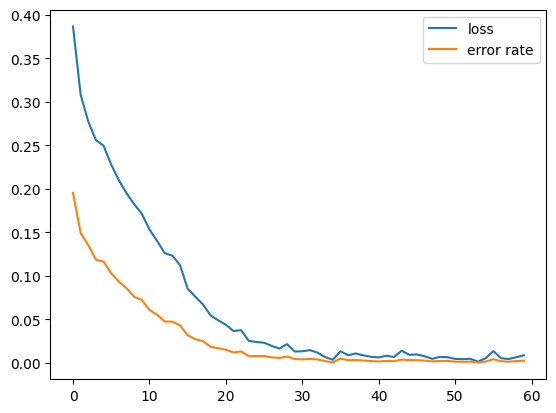

In [24]:
loss_history, err_rate_history = train_loop(train_loader, model, optimizer, num_epochs=60, verbose=True)
plt.plot(loss_history, label = "loss")
plt.plot(err_rate_history, label="error rate")
plt.legend()
plt.show()

In [25]:
torch.save(model.state_dict(), "../../models/LSTM_glove200_60ep.model")
model.load_state_dict(torch.load("../../models/LSTM_glove200_60ep.model"))
model = model.to(device)

## Testing

In [26]:
test_model(test_loader, model)

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.543439 



In [27]:
test_model(train_loader, model)

Test Error: 
 Accuracy: 99.7%, Avg loss: 0.007981 



In [36]:
boundary = 0.01

In [37]:
test_high_confidence(test_loader, model, low_boundary=boundary)

High confidence samples: 1709/1886 = 90.62%
Accuracy for high confidence samples: 93.9%


In [38]:
all_moves_df = datasets.load_sql_to_df("SELECT * FROM english_annotated_moves", "../../chess.db",)[important_columns]
all_moves_df

,position,move,comment,sentiment
0,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,e2e4,This is my first gameknot game against someone...,2
1,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,b1c3,"I've been playing the Vienna Gambit as white, ...",-1
2,rnbqkbnr/pppp1ppp/8/4p3/4P3/2N5/PPPP1PPP/R1BQK...,f8c5,Minor disappointment.,-1
3,r1bqk2r/pppp1ppp/2n2n2/2b1p3/2B1P3/2NP4/PPP2PP...,f2f4,"My idea here is to expand on the kingside, dri...",-1
4,r1bqk2r/ppp2ppp/3p1n2/n1b1pP2/2B1P3/2NP4/PPP3P...,d1f3,"Maybe this isn't the greatest plan, since with...",0
...,...,...,...,...
326634,rnb5/p2p1P1N/7p/1pR5/6P1/4k3/2P1B3/3Q1RK1 b - ...,b5b4,Pawn,-1
326635,rnb5/p2p1P1N/7p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 w -...,f7f8q,Check mate in two moves,-1
326636,rnb2Q2/p2p3N/7p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 b -...,d7d6,Pawn,-1
326637,rnb2Q2/p6N/3p3p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 w -...,f8e8,Check,-1


In [39]:
moves_df_with_preprocessed_comments = dp.prepare_data_for_sentiment_analysis_prediction(all_moves_df, glove_embbedings.stoi)
moves_df_with_preprocessed_comments

,position,move,comment,sentiment,preprocessed_comment
81251,r1bqkbnr/pp1p1ppp/2n5/2p1p3/7P/2NP3R/PPP1PPP1/...,d7d5,so i did d7-d5,-1,"[so, do]"
139666,r2q1rk1/pp2bppp/2p1pnb1/4N1B1/2Q5/3P2N1/PPP2PP...,f6d5,Possible was 13. ... Qd5! 14. Nxg6 fg! 15.Qh4 h6,-1,"[possible, be]"
222593,8/2P2pkp/6p1/pP6/P3r1P1/6KP/4pP2/4R3 b - - 0 40,e4c4,Only move,-1,"[only, move]"
231547,8/8/8/8/5K2/6Q1/7k/8 b - - 14 63,h2h1,Only move,-1,"[only, move]"
46704,rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBN...,f1c4,and....,-1,"[and, ....]"
...,...,...,...,...,...
265121,8/3b4/2p2kp1/pp2p2p/4P3/1P1P1NP1/P1P4P/6K1 w -...,d3d4,"? Knowing that I'm still a pawn up, I, once ag...",0,"[?, know, that, be, still, a, pawn, up, once, ..."
170837,r2qk2r/ppp2ppp/2np4/2b1p2b/4P3/2NP1N1P/PPP2PP1...,c3d5,"Since he does not make the capture, I do not k...",-1,"[since, he, do, not, make, the, capture, do, n..."
121703,r5k1/7p/1qn5/p1p2QP1/P7/1N5P/1bP5/3R3K w - - 1 30,d1d7,Threatening checkmate. The only defense to thi...,-1,"[threaten, checkmate, ., the, only, defense, t..."
26749,r4r1k/p5q1/bp2p1B1/2ppP3/6R1/2P3P1/PPQ2b1N/R6K...,f2e3,"I stop the threat, while preparing to get my b...",-1,"[stop, the, threat, while, prepare, to, get, m..."


In [25]:
moves_df_with_preprocessed_comments = moves_df_with_preprocessed_comments.reset_index()
moves_df_with_preprocessed_comments

,index,position,move,comment,sentiment,preprocessed_comment
0,0,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,e2e4,This is my first gameknot game against someone...,2,"[this, be, my, first, game, against, someone, ..."
1,1,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,b1c3,"I've been playing the Vienna Gambit as white, ...",-1,"['ve, be, play, the, vienna, gambit, as, white..."
2,2,rnbqkbnr/pppp1ppp/8/4p3/4P3/2N5/PPPP1PPP/R1BQK...,f8c5,Minor disappointment.,-1,"[minor, disappointment, .]"
3,3,r1bqk2r/pppp1ppp/2n2n2/2b1p3/2B1P3/2NP4/PPP2PP...,f2f4,"My idea here is to expand on the kingside, dri...",-1,"[my, idea, here, be, to, expand, on, the, king..."
4,4,r1bqk2r/ppp2ppp/3p1n2/n1b1pP2/2B1P3/2NP4/PPP3P...,d1f3,"Maybe this isn't the greatest plan, since with...",0,"[maybe, this, be, not, the, great, plan, since..."
...,...,...,...,...,...,...
309464,326606,rnb5/ppppk2N/2n4p/3Nb3/5qP1/P4P2/1PP1B3/R2Q1RK...,e7d6,Black left their queen hanging so I can take i...,-1,"[black, leave, their, queen, hang, so, can, ta..."
309465,326607,rnb5/pppp3N/2nk3p/3Nb3/5qP1/P4P2/1PP1B3/R2Q1RK...,d5f4,Takes queen,-1,"[take, queen]"
309466,326625,rnb5/pppp3N/7p/1R3P2/4k1P1/8/2P1B3/3Q1RK1 w - ...,f5f6,Right here when I starting if I can get pawn t...,-1,"[right, here, when, start, if, can, get, pawn,..."
309467,326629,rnb5/pp1p3N/2p2P1p/8/1R4P1/4k3/2P1B3/3Q1RK1 w ...,f6f7,Almost to other side,-1,"[almost, to, other, side]"


In [40]:
unlabeled_dataset = datasets.PretrainedEmbeddingsIndicesDataset(moves_df_with_preprocessed_comments, glove_embbedings, comment_col="preprocessed_comment")
unlabeled_loader = datasets.DataLoaderPadding(dataset=unlabeled_dataset, batch_size = 128)
predictions = predict(unlabeled_loader, model, low_boundary=0.1)
moves_df_with_preprocessed_comments.loc[:, "sentiment"] = predictions.numpy().astype(np.int32)
# moves_df_with_preprocessed_comments[moves_df_with_preprocessed_comments.sentiment.isin([0,1])]
moves_df_with_preprocessed_comments

,position,move,comment,sentiment,preprocessed_comment
81251,r1bqkbnr/pp1p1ppp/2n5/2p1p3/7P/2NP3R/PPP1PPP1/...,d7d5,so i did d7-d5,-1,"[so, do]"
139666,r2q1rk1/pp2bppp/2p1pnb1/4N1B1/2Q5/3P2N1/PPP2PP...,f6d5,Possible was 13. ... Qd5! 14. Nxg6 fg! 15.Qh4 h6,0,"[possible, be]"
222593,8/2P2pkp/6p1/pP6/P3r1P1/6KP/4pP2/4R3 b - - 0 40,e4c4,Only move,1,"[only, move]"
231547,8/8/8/8/5K2/6Q1/7k/8 b - - 14 63,h2h1,Only move,1,"[only, move]"
46704,rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBN...,f1c4,and....,1,"[and, ....]"
...,...,...,...,...,...
265121,8/3b4/2p2kp1/pp2p2p/4P3/1P1P1NP1/P1P4P/6K1 w -...,d3d4,"? Knowing that I'm still a pawn up, I, once ag...",0,"[?, know, that, be, still, a, pawn, up, once, ..."
170837,r2qk2r/ppp2ppp/2np4/2b1p2b/4P3/2NP1N1P/PPP2PP1...,c3d5,"Since he does not make the capture, I do not k...",0,"[since, he, do, not, make, the, capture, do, n..."
121703,r5k1/7p/1qn5/p1p2QP1/P7/1N5P/1bP5/3R3K w - - 1 30,d1d7,Threatening checkmate. The only defense to thi...,1,"[threaten, checkmate, ., the, only, defense, t..."
26749,r4r1k/p5q1/bp2p1B1/2ppP3/6R1/2P3P1/PPQ2b1N/R6K...,f2e3,"I stop the threat, while preparing to get my b...",1,"[stop, the, threat, while, prepare, to, get, m..."


In [41]:
classified_comments = moves_df_with_preprocessed_comments[moves_df_with_preprocessed_comments.sentiment.isin([0,1])]
classified_comments

,position,move,comment,sentiment,preprocessed_comment
139666,r2q1rk1/pp2bppp/2p1pnb1/4N1B1/2Q5/3P2N1/PPP2PP...,f6d5,Possible was 13. ... Qd5! 14. Nxg6 fg! 15.Qh4 h6,0,"[possible, be]"
222593,8/2P2pkp/6p1/pP6/P3r1P1/6KP/4pP2/4R3 b - - 0 40,e4c4,Only move,1,"[only, move]"
231547,8/8/8/8/5K2/6Q1/7k/8 b - - 14 63,h2h1,Only move,1,"[only, move]"
46704,rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBN...,f1c4,and....,1,"[and, ....]"
3084,r1q1r1k1/pp3pp1/2p2n2/2Nn3p/1PQN2b1/6P1/P2RPP1...,a7a6,Defensive.,1,"[defensive, .]"
...,...,...,...,...,...
265121,8/3b4/2p2kp1/pp2p2p/4P3/1P1P1NP1/P1P4P/6K1 w -...,d3d4,"? Knowing that I'm still a pawn up, I, once ag...",0,"[?, know, that, be, still, a, pawn, up, once, ..."
170837,r2qk2r/ppp2ppp/2np4/2b1p2b/4P3/2NP1N1P/PPP2PP1...,c3d5,"Since he does not make the capture, I do not k...",0,"[since, he, do, not, make, the, capture, do, n..."
121703,r5k1/7p/1qn5/p1p2QP1/P7/1N5P/1bP5/3R3K w - - 1 30,d1d7,Threatening checkmate. The only defense to thi...,1,"[threaten, checkmate, ., the, only, defense, t..."
26749,r4r1k/p5q1/bp2p1B1/2ppP3/6R1/2P3P1/PPQ2b1N/R6K...,f2e3,"I stop the threat, while preparing to get my b...",1,"[stop, the, threat, while, prepare, to, get, m..."
